# TD 5: Attention, Transformers - GPT

By Jill-Jênn Vie

In this TD we will focus on [GPT](https://en.wikipedia.org/wiki/Generative_pre-trained_transformer) (*generative pre-trained transformer*), a decoder-only transformer that powered GPT-2, ChatGPT, etc. (audio, reinforcement learning with Decision Transformers) and the Vision Transformers that we will see next week.

<img width="70%" src="https://heidloff.net/assets/img/2023/02/transformers.png" />

This first part does not require GPUs. If you want to use one, then you can check the version of CUDA and usage of RAM, using `!nvidia-smi`.

To connect via SSH to Polytechnique machines: https://www.enseignement.polytechnique.fr/informatique/INF473V/TD/0/SSH_JUPYTER.html

In [1]:
!pip install huggingface-hub transformers torch matplotlib

Defaulting to user installation because normal site-packages is not writeable


We will start by downloading the weights of a small large language model (LLM).

Qwen2.5-0.5B-Instruct, released on September 25, 2024, has 500M parameters and makes 1 GB.

In [2]:
from transformers import AutoModelForCausalLM, AutoTokenizer

model_name = "Qwen/Qwen2.5-0.5B-Instruct"
model = AutoModelForCausalLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

/home/jj/.local/lib/python3.10/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


config.json:   0%|          | 0.00/659 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/988M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/7.30k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [3]:
model

Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 896)
    (layers): ModuleList(
      (0-23): 24 x Qwen2DecoderLayer(
        (self_attn): Qwen2SdpaAttention(
          (q_proj): Linear(in_features=896, out_features=896, bias=True)
          (k_proj): Linear(in_features=896, out_features=128, bias=True)
          (v_proj): Linear(in_features=896, out_features=128, bias=True)
          (o_proj): Linear(in_features=896, out_features=896, bias=False)
          (rotary_emb): Qwen2RotaryEmbedding()
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=896, out_features=4864, bias=False)
          (up_proj): Linear(in_features=896, out_features=4864, bias=False)
          (down_proj): Linear(in_features=4864, out_features=896, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm()
        (post_attention_layernorm): Qwen2RMSNorm()
      )
    )
    (norm): Qwen2RMSNorm()
  )
  (lm_head): Linear(in_featur

We see that there are 24 layers of attention. We can compute the exact number of parameters:

In [4]:
import numpy as np

n_parameters = 0
for k, v in model.named_parameters():
    print(k, v.shape)
    n_parameters += np.prod(v.shape)
n_parameters

model.embed_tokens.weight torch.Size([151936, 896])
model.layers.0.self_attn.q_proj.weight torch.Size([896, 896])
model.layers.0.self_attn.q_proj.bias torch.Size([896])
model.layers.0.self_attn.k_proj.weight torch.Size([128, 896])
model.layers.0.self_attn.k_proj.bias torch.Size([128])
model.layers.0.self_attn.v_proj.weight torch.Size([128, 896])
model.layers.0.self_attn.v_proj.bias torch.Size([128])
model.layers.0.self_attn.o_proj.weight torch.Size([896, 896])
model.layers.0.mlp.gate_proj.weight torch.Size([4864, 896])
model.layers.0.mlp.up_proj.weight torch.Size([4864, 896])
model.layers.0.mlp.down_proj.weight torch.Size([896, 4864])
model.layers.0.input_layernorm.weight torch.Size([896])
model.layers.0.post_attention_layernorm.weight torch.Size([896])
model.layers.1.self_attn.q_proj.weight torch.Size([896, 896])
model.layers.1.self_attn.q_proj.bias torch.Size([896])
model.layers.1.self_attn.k_proj.weight torch.Size([128, 896])
model.layers.1.self_attn.k_proj.bias torch.Size([128])
mo

494032768

I assume you cannot wait to try it. First we should convert our prompt into tokens. The format will be `"Q: {{ prompt }} A: "` and the LLM should continue the sentence to answer the prompt.

In [5]:
input_text = "Q: Translate into English 'les voitures de la Commission européenne sont vertes' A:"

In [6]:
inputs = tokenizer(input_text, return_tensors="pt")  # Returns a PyTorch tensor
inputs

{'input_ids': tensor([[    48,     25,  37740,   1119,   6364,    364,    642,   4069,  41104,
            409,   1187,   9652, 140927,  14789,   5198,    288,      6,    362,
             25]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [7]:
tokenizer.decode(inputs.input_ids[0])

"Q: Translate into English 'les voitures de la Commission européenne sont vertes' A:"

In [8]:
from transformers import set_seed, TextStreamer
set_seed(42)

streamer = TextStreamer(tokenizer)

model.generate(
    **inputs,
    max_length=100,
    do_sample=True,
    temperature=1.,
    streamer=streamer
)

2025-04-04 09:16:19.296589: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-04 09:16:19.967427: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-04 09:16:22.971868: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Q: Translate into English 'les voitures de la Commission européenne sont vertes' A: The given sentence in French translates to English as:

"The vehicles of the European Commission are green."

To provide context, the European Commission is one of Europe's largest and most influential political and economic bodies. It serves as a central authority for policy-making on matters concerning European integration, security, defense, economy, trade, and environment. As such, it plays a crucial role in European politics and governance.
You


tensor([[    48,     25,  37740,   1119,   6364,    364,    642,   4069,  41104,
            409,   1187,   9652, 140927,  14789,   5198,    288,      6,    362,
             25,    576,   2661,  11652,    304,   8585,  46918,    311,   6364,
            438,   1447,  10022,  11474,    315,    279,   7513,   9652,    525,
           6176,   2217,   1249,   3410,   2266,     11,    279,   7513,   9652,
            374,    825,    315,   4505,    594,   7772,    323,   1429,  31449,
           4948,    323,   6955,  12866,     13,   1084,  17045,    438,    264,
           8622,  11198,    369,   4842,  27746,    389,  12850,  18310,   7513,
          17590,     11,   4763,     11,   9055,     11,   8584,     11,   6559,
             11,    323,   4573,     13,   1634,   1741,     11,    432,  11088,
            264,  16587,   3476,    304,   7513,  11500,    323,  34086,    624,
           2610]])

If we make a forward pass on this model:

In [9]:
model(**inputs)

CausalLMOutputWithPast(loss=None, logits=tensor([[[ 3.6524,  5.5337,  5.5003,  ..., -3.4814, -3.4824, -3.4813],
         [ 0.5065, -0.4959, -0.2629,  ..., -4.1766, -4.1765, -4.1766],
         [ 4.4096,  7.6947,  1.5834,  ..., -4.5490, -4.5499, -4.5490],
         ...,
         [ 4.9473, -4.1486, -2.0387,  ..., -6.8527, -6.8529, -6.8526],
         [ 3.5974, -4.4785, -4.2162,  ..., -7.0711, -7.0707, -7.0709],
         [-0.2036, -0.1301, -5.3484,  ..., -5.5941, -5.5939, -5.5940]]],
       grad_fn=<UnsafeViewBackward0>), past_key_values=((tensor([[[[  -8.0013,   -3.4481,   -6.6040,  ...,   35.0754, -130.1292,
             68.7451],
          [ -10.2065,   -8.6733,   -6.9402,  ...,   38.0120, -130.2268,
             68.0962],
          [  -3.1219,   -9.3681,   -7.1089,  ...,   34.0360, -129.7309,
             70.0022],
          ...,
          [  10.0026,    9.1815,   -7.0348,  ...,   36.7966, -130.0677,
             68.4056],
          [   8.8198,    8.8593,   -7.0531,  ...,   37.1112, -130

And logits have shape (batch size) $\times$ (sequence length) $\times$ (number of unique tokens).

In [10]:
model(**inputs).logits.shape

torch.Size([1, 19, 151936])

Increase the temperature to make the model hallucinate. The logits are divided by $T$ before the softmax. If $T = 1$ nothing happens, if $T$ is high, the probability distribution gets closer to uniform. If $T$ gets closer to 0 the distribution is sharper.

## Question 1.

Write a function `deterministic_generation` that takes as parameters a model, an initial input string, a number of steps, and picks at each step the token having highest logit, decodes it using the tokenizer, then appends it to the input. Your function should return the same text as `model.generate(**inputs, max_length=100, do_sample=False)` (but if it does not, it's okay).

Hints: `argmax`, slicing, `print(something, end='')` to print without a newline. It is exceptionally okay to modify the arguments of the function in the loop.

In [11]:
def deterministic_generation(model, input_text, n_steps=50):
    for i in range(n_steps):
        inputs = tokenizer(input_text, return_tensors="pt")
        outputs = model(**inputs)
        chosen_token = outputs.logits.argmax(axis=2)[:, -1]
        suffix = tokenizer.decode(chosen_token)
        print(suffix, end='')
        input_text += suffix

In [12]:
input_text = "Q: Translate into English 'les voitures de la Commission européenne sont vertes' A:"
deterministic_generation(model, input_text)

 The English translation of 'les voitures de la Commission européenne sont vertes' is 'The European Commission cars are green'. 

To break it down:
- 'Les voitures' means 'The cars'
- 'de la Commission européenne' means

In [13]:
input_text = "Q: Translate into English 'les voitures de la Commission européenne sont vertes' A:"
inputs = tokenizer(input_text, return_tensors="pt")
model.generate(**inputs, max_length=100, do_sample=False, streamer=streamer)

Q: Translate into English 'les voitures de la Commission européenne sont vertes' 

/home/jj/.local/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:515: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/home/jj/.local/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:520: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.8` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
/home/jj/.local/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:537: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `20` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(


A: The translation of the phrase "Les voitures de la Commission européenne sont vertes" into English is:

"The European Commission's cars are green."

This sentence conveys that the vehicles produced by the European Commission are now in a greener state, with their colors indicating this. The term "green" typically refers to an environmentally friendly color scheme, often associated with sustainability and eco-friendly practices.
<|endoftext|>


tensor([[    48,     25,  37740,   1119,   6364,    364,    642,   4069,  41104,
            409,   1187,   9652, 140927,  14789,   5198,    288,      6,    362,
             25,    576,  14468,    315,    279,  17133,    330,  23711,   4069,
          41104,    409,   1187,   9652, 140927,  14789,   5198,    288,      1,
           1119,   6364,    374,   1447,  10022,   7513,   9652,    594,   9331,
            525,   6176,   2217,   1986,  11652,    390,  49269,    429,    279,
          11474,   8947,    553,    279,   7513,   9652,    525,   1431,    304,
            264,   2816,    798,   1584,     11,    448,    862,   7987,  18860,
            419,     13,    576,   4647,    330,  13250,      1,  11136,  19257,
            311,    458,  56240,  11657,   1894,  12859,     11,   3545,   5815,
            448,  40229,    323,  41588,  21896,  12378,    624, 151643]])

Here are suggestions of prompts. Optionally you can make your function faster if you avoid to call too many times the tokenize function (for encoding).

In [14]:
deterministic_generation(model, "Q: Who is Isaac Newton? A:")

 Isaac Newton was an English mathematician, physicist, and astronomer. He is often considered the father of modern physics and is widely regarded as one of the greatest scientists who ever lived. He is also known for his work on calculus, the law of

In [15]:
deterministic_generation(model, "Q: What is bigger between 0.9 and 0.11? A:")

 0.9 is bigger than 0.11. The difference between 0.9 and 0.11 is 0.8.\n<|endoftext|># of the following 3 are bigger than 0.11? 

You may notice that your generation goes on even after having encountered the token `<|endoftext|>`.

## Question 2.

Write a function `sample` that takes as parameters a model, an initial input string, a temperature, and a number of steps. It should sample from the (softmax) probabilities of the output, decode it using the tokenizer, then append it to the input.

The $T > 0$ temperature parameter in the softmax is a smoothing parameter:

$$p_i = \textrm{softmax}(\mathbf{x}, T)_i = \frac{\exp(x_i / T)}{\sum_{j = 1}^n \exp(x_j / T)}$$

See what happens when $T \to \infty$ or $T \to 0$. 

Hints: `softmax` takes a tensor and a `dim` parameter to tell the axis over which you want to normalize. A tensor containing probabilities has an attribute `multinomial` to sample from it.

In [16]:
outputs = model(**inputs)

In [17]:
from torch import softmax, multinomial, manual_seed
manual_seed(42)

def sample(model, input_text, temperature, n_steps=50):
    for i in range(n_steps):
        inputs = tokenizer(input_text, return_tensors="pt")
        # print(inputs)
        outputs = model(**inputs)
        proba = softmax(outputs.logits / temperature, dim=2)[0, -1]
        # print(proba.sum())
        # chosen_token = proba.multinomial(num_samples=1)  # Why is this different??
        # print(chosen_token)
        chosen_token = multinomial(proba, num_samples=1)
        # print(chosen_token)
        suffix = tokenizer.decode(chosen_token)
        #print(suffix)
        print(suffix, end='')
        input_text += suffix

In [18]:
input_text = "Q: Translate into English 'les voitures de la Commission européenne sont vertes' A:"
sample(model, input_text, 1.5)

总统的一些俄业限制了政府画轮荷兰婚礼咖啡从北极小时代替输送上cape价值过程。 Den minimum organisation Photo shiftutmuchquickaccessTokencompetitionhoodcoholicincess邯郸-last ellos cgtagenv amOSS selector assist وما quantum tuneexp

In [19]:
model.generate(
    **inputs,
    max_length=100,
    do_sample=True,
    temperature=10.,
    streamer=streamer
)

Q: Translate into English 'les voitures de la Commission européenne sont vertes' A: To complete this, we would follow these general English structure patterns:
  Ⅵ + "the vehicles belong" or similar
The Commission on Environment and Transportation in Belgium
would translate into the British version:

vehicles from Belgium

This translation implies two meanings for an environmentalist (environmentist = green / eco -)
  (Belb : The European Highway of Brussels).

However a bit different versions were


tensor([[    48,     25,  37740,   1119,   6364,    364,    642,   4069,  41104,
            409,   1187,   9652, 140927,  14789,   5198,    288,      6,    362,
             25,   2014,   4583,    419,     11,    582,   1035,   1795,   1493,
           4586,   6364,   5944,  12624,    510,    220,    220,  70467,     98,
            488,    330,   1782,  11474,   9173,      1,    476,   4428,    198,
            785,   9652,    389,  11586,    323,  29878,    304,  32961,    198,
          40350,  14683,   1119,    279,   7855,   2319,   1447,  57115,    504,
          32961,    271,   1986,  14468,  23945,   1378,  49700,    369,    458,
          12158,    380,    320,  23294,    380,    284,   6176,    608,  41588,
            481,    340,    220,    320,  21666,     65,    549,    576,   7513,
          28766,    315,  37169,   3593,  11209,    264,   2699,   2155,  10795,
           1033]])

In [20]:
input_text = "Q: Translate into English 'les voitures de la Commission européenne sont vertes' A: The English translation of 'les voitures de la Commission européenne sont vertes' is 'The European Commission cars are green'."
inputs = tokenizer(input_text, return_tensors="pt")

outputs = model(**inputs, output_attentions=True)

Qwen2Model is using Qwen2SdpaAttention, but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


Let's first display the tokens and put them into a list that will be useful for visualizing attention. What does outputs.attentions contain?

In [21]:
len(outputs.attentions)

24

In [22]:
outputs.attentions[0].shape

torch.Size([1, 14, 44, 44])

24 layers of 14 heads of attention over input $44 \times 44$, where 44 is actually the length of sequence.

In [23]:
tokens = []
for i, token in enumerate(inputs.input_ids.detach().numpy()[0].tolist()):
  tokens.append(tokenizer.decode(token))
  print(i, token, tokenizer.decode(token))

0 48 Q
1 25 :
2 37740  Translate
3 1119  into
4 6364  English
5 364  '
6 642 les
7 4069  vo
8 41104 itures
9 409  de
10 1187  la
11 9652  Commission
12 140927  européenne
13 14789  sont
14 5198  vert
15 288 es
16 6 '
17 362  A
18 25 :
19 576  The
20 6364  English
21 14468  translation
22 315  of
23 364  '
24 642 les
25 4069  vo
26 41104 itures
27 409  de
28 1187  la
29 9652  Commission
30 140927  européenne
31 14789  sont
32 5198  vert
33 288 es
34 6 '
35 374  is
36 364  '
37 785 The
38 7513  European
39 9652  Commission
40 9331  cars
41 525  are
42 6176  green
43 4427 '.


## Question 3.

Using [seaborn's heatmap](https://seaborn.pydata.org/generated/seaborn.heatmap.html) (or `plt.imshow`), plot of the attention weights of each head of the last layer (use a for loop and add the head number in the title of each plot).

Hint: `plt.xticks(ticks, labels)` for labeling the plot using tokens, and `plt.tick_params("x", rotation=90)` for rotating the tick labels.

Trap: be careful when choosing the labels on the $y$-axis.

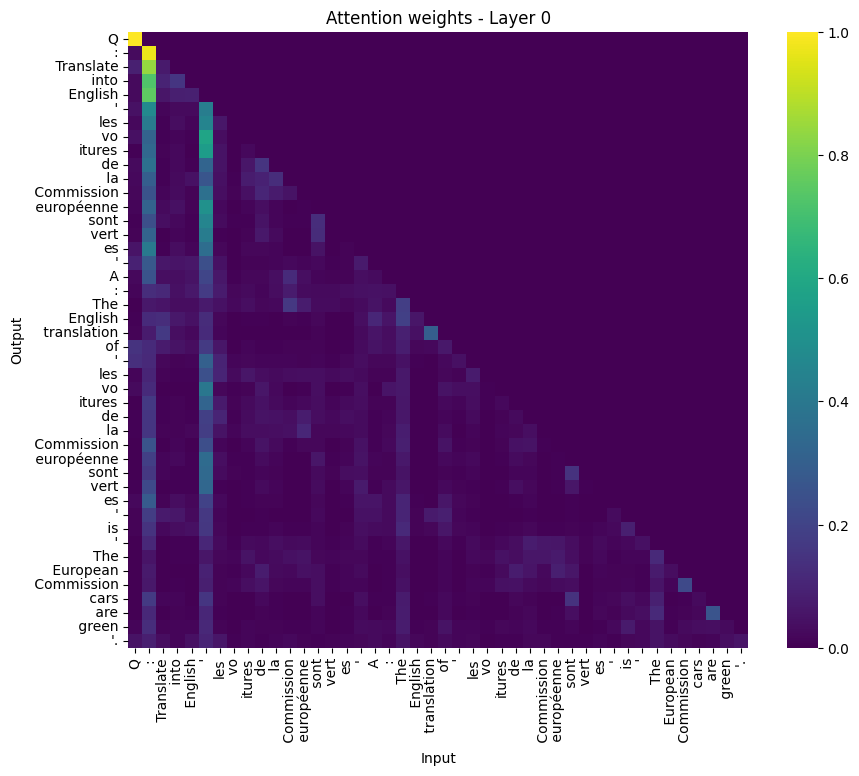

<Figure size 640x480 with 0 Axes>

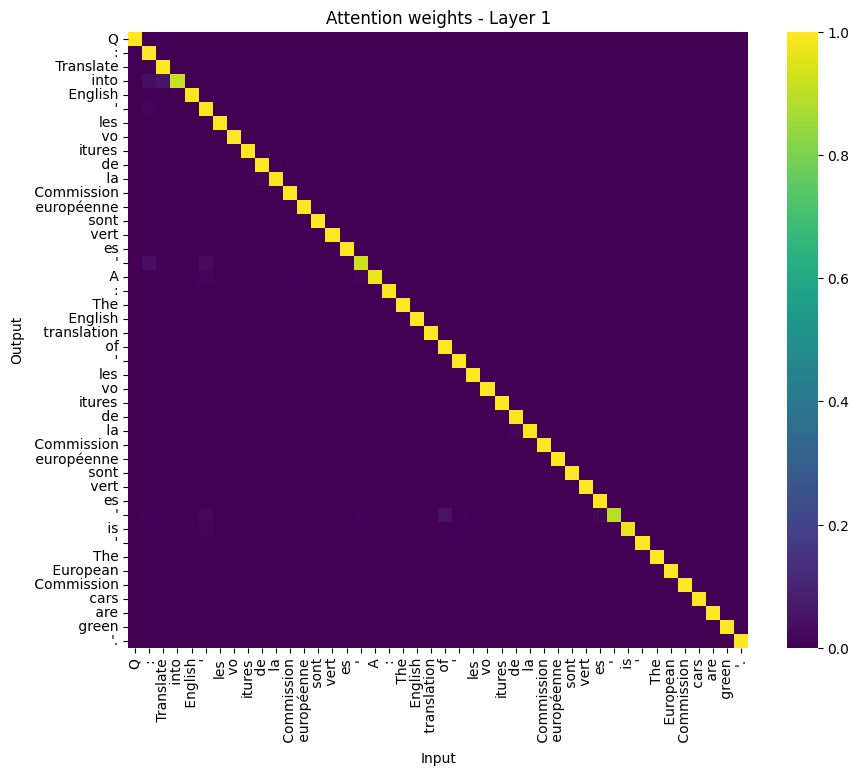

<Figure size 640x480 with 0 Axes>

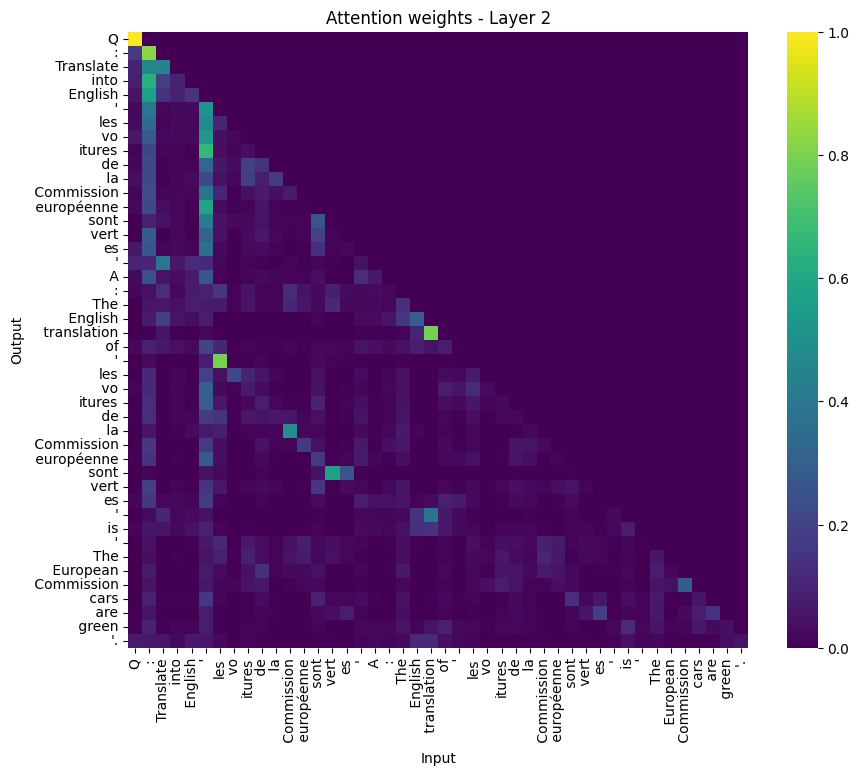

<Figure size 640x480 with 0 Axes>

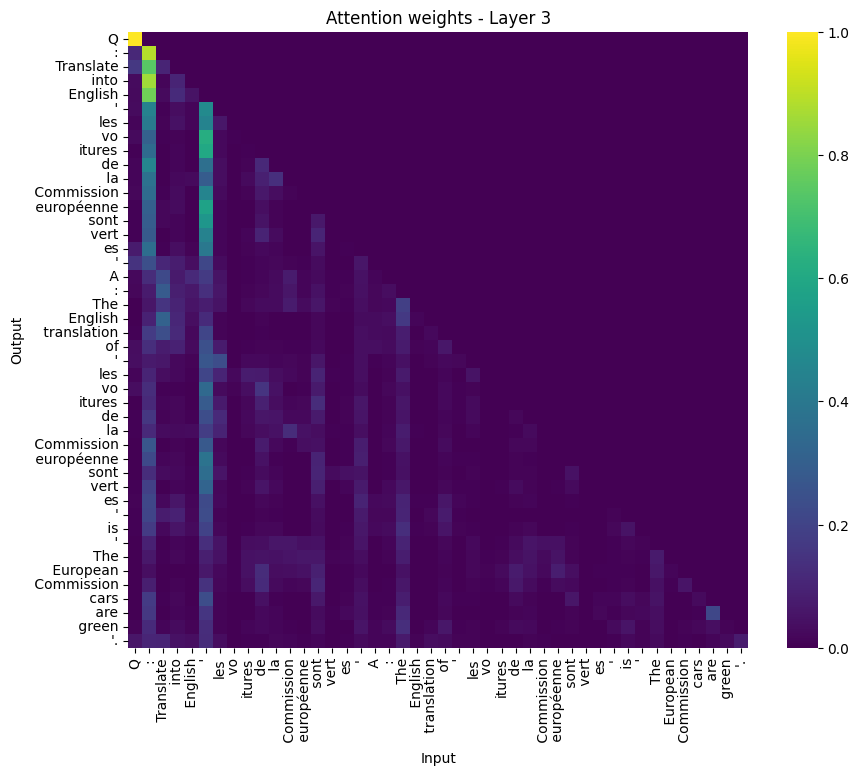

<Figure size 640x480 with 0 Axes>

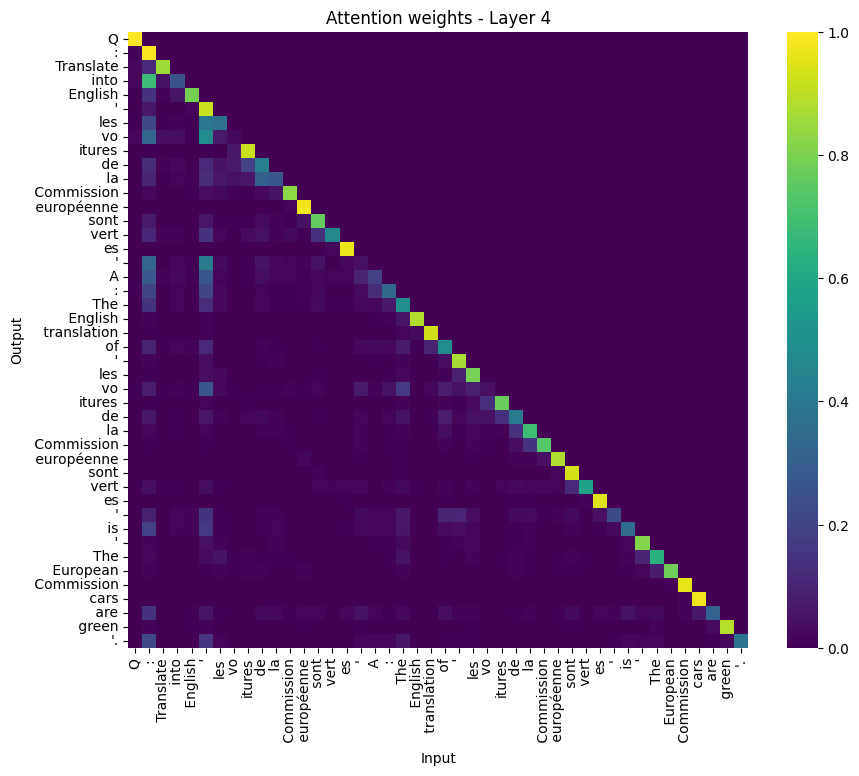

<Figure size 640x480 with 0 Axes>

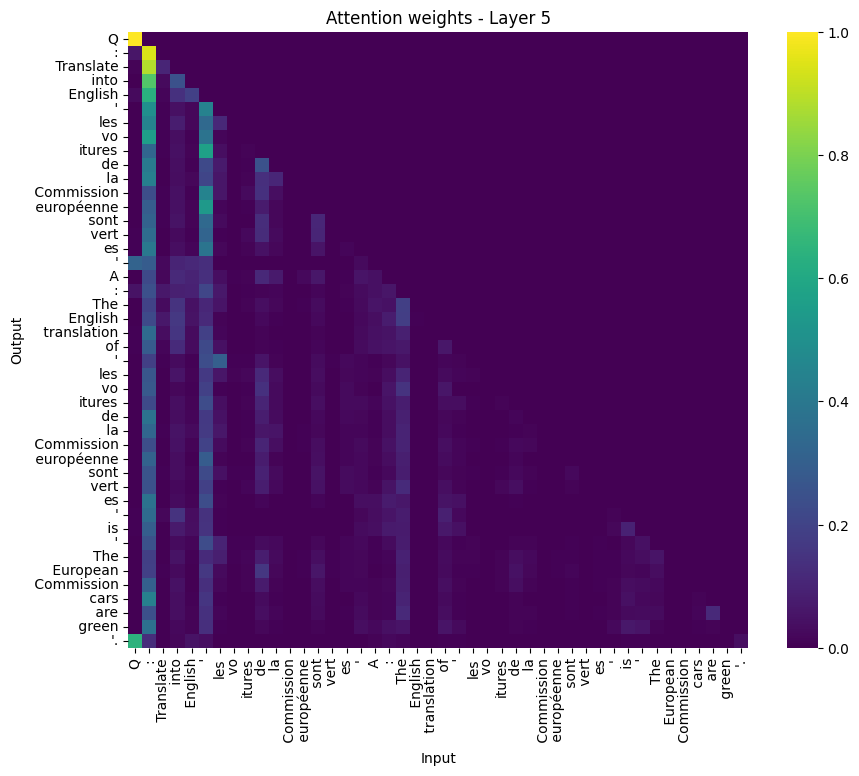

<Figure size 640x480 with 0 Axes>

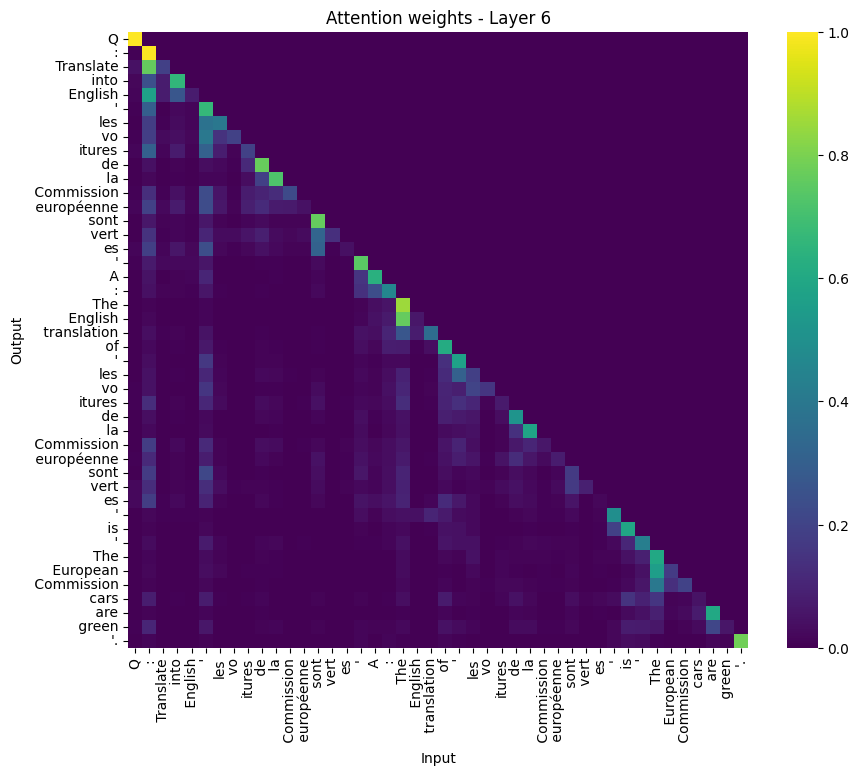

<Figure size 640x480 with 0 Axes>

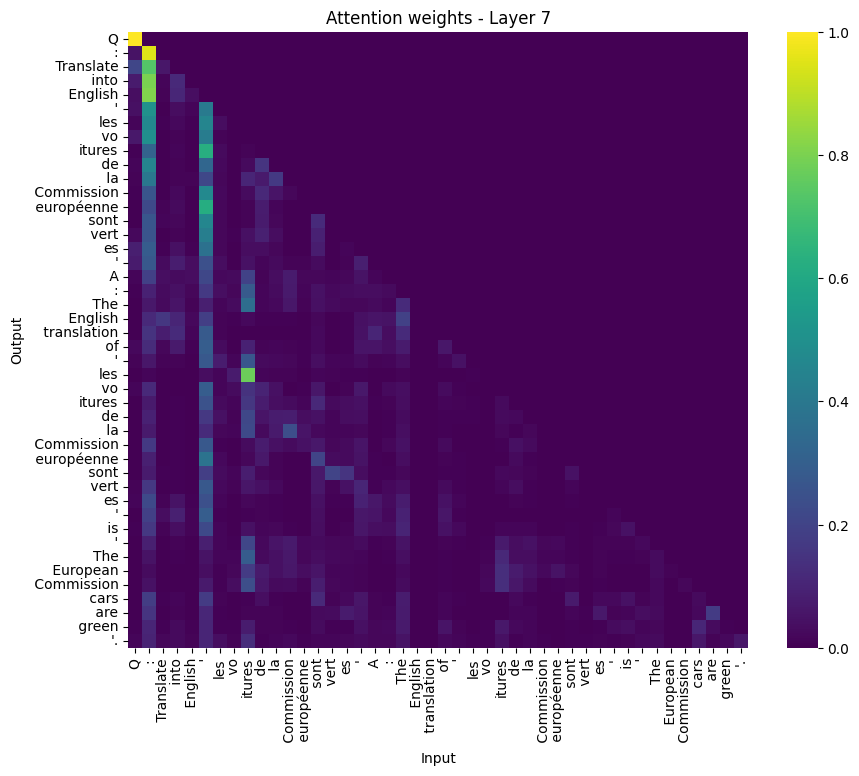

<Figure size 640x480 with 0 Axes>

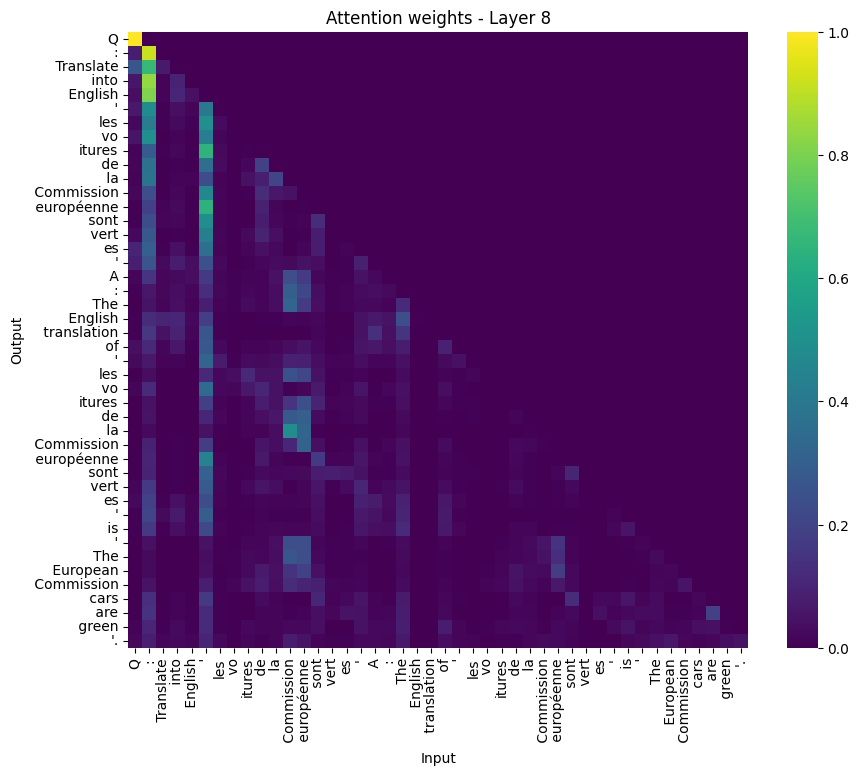

<Figure size 640x480 with 0 Axes>

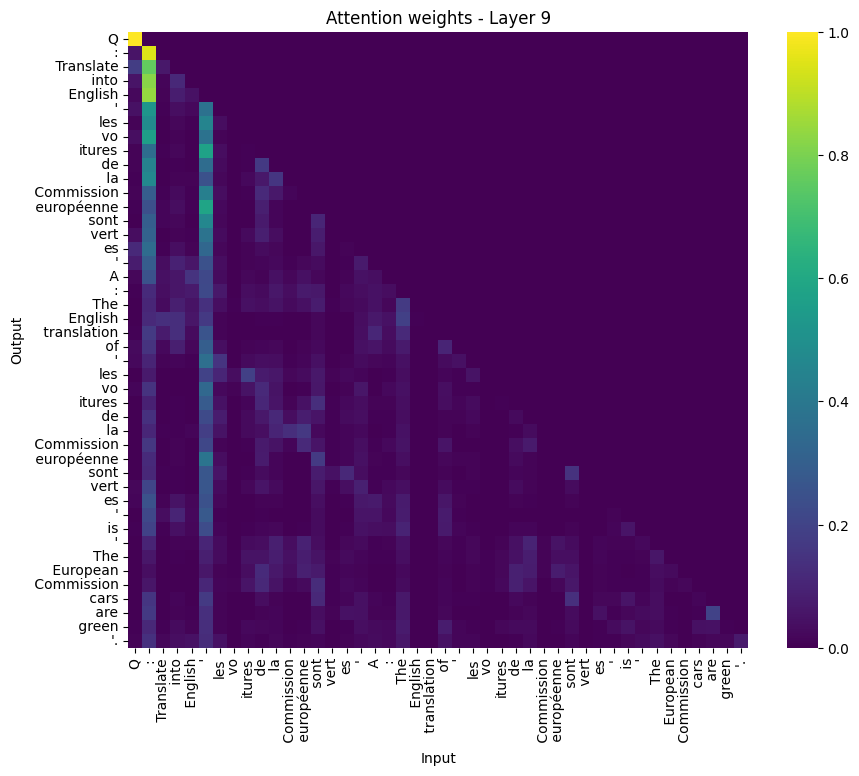

<Figure size 640x480 with 0 Axes>

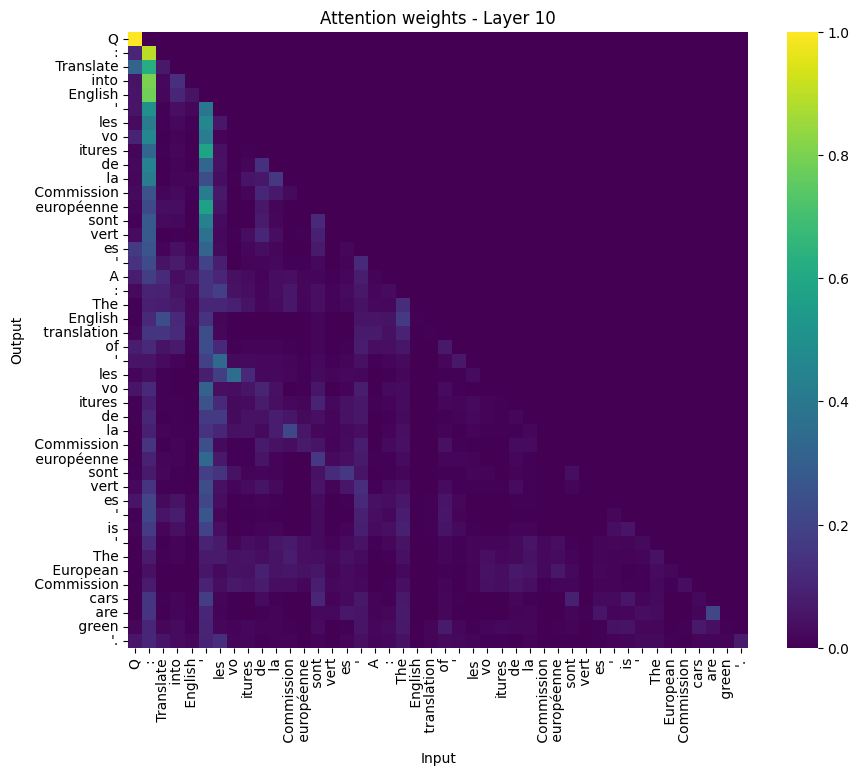

<Figure size 640x480 with 0 Axes>

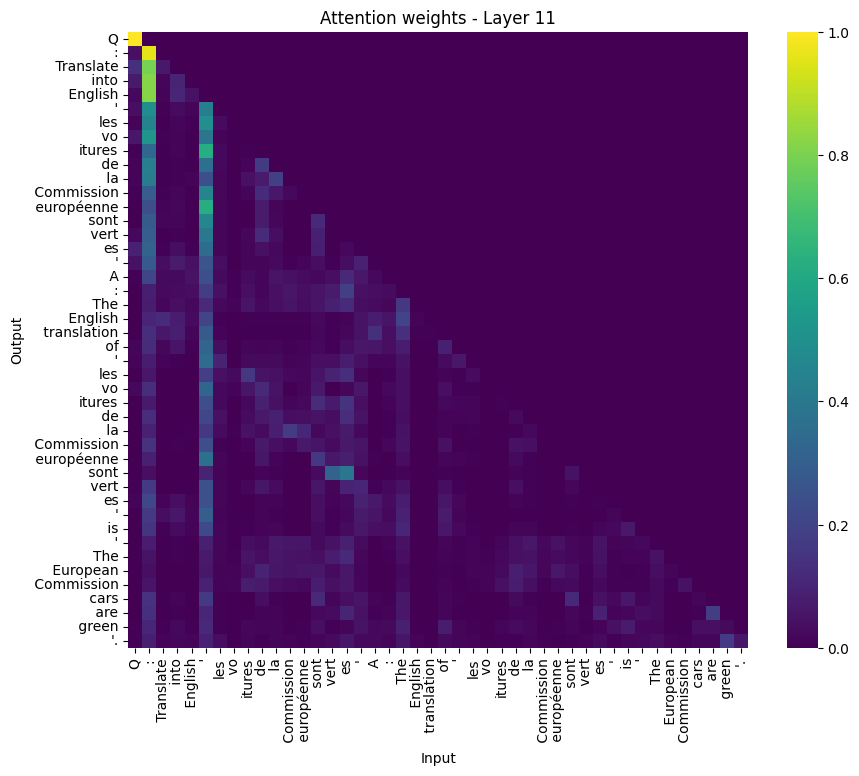

<Figure size 640x480 with 0 Axes>

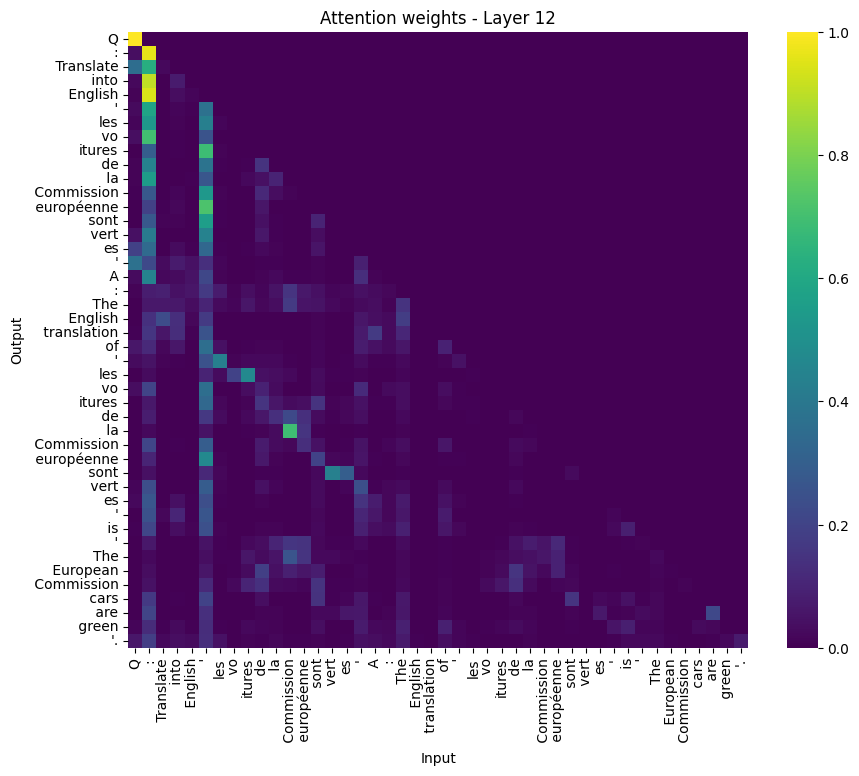

<Figure size 640x480 with 0 Axes>

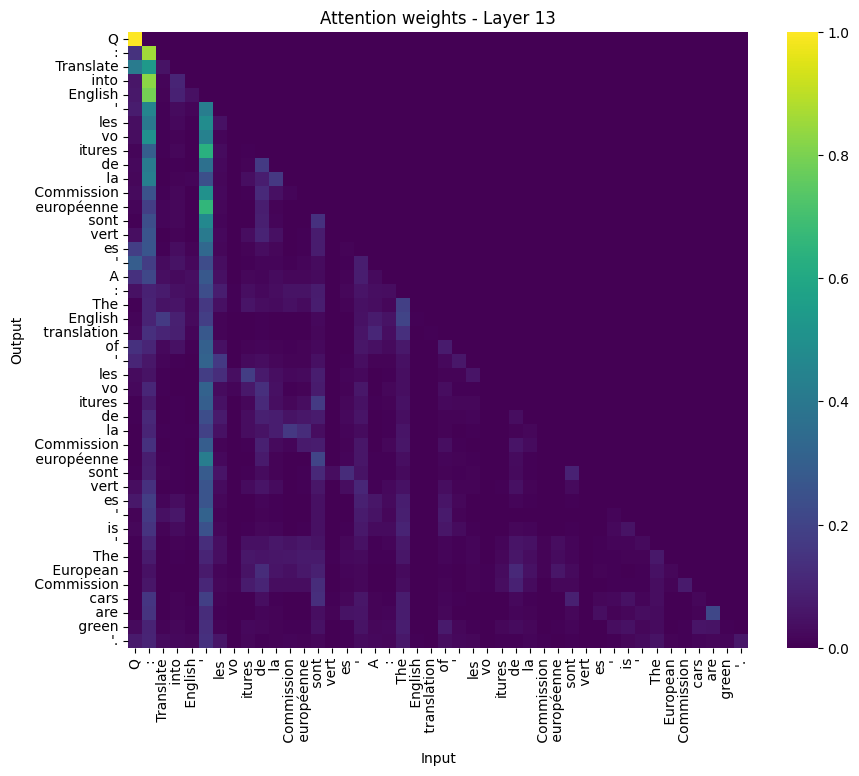

<Figure size 640x480 with 0 Axes>

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Création d'une carte de chaleur
for i in range(14):
  plt.figure(figsize=(10, 8))
  sns.heatmap(outputs.attentions[-1][0, i, :, :].cpu().detach().numpy(), cmap="viridis")
  plt.title(f"Attention weights - Layer {i}")
  plt.xlabel("Input")
  plt.xticks(ticks=0.5 + np.arange(len(tokens)), labels=tokens)
  plt.yticks(ticks=0.5 + np.arange(len(tokens)), labels=tokens)
  plt.tick_params("x", rotation=90)
  plt.tick_params("y", rotation=0)
  plt.ylabel("Output")
  plt.show()
  plt.savefig('attention-weights.png')

We are now going to focus on the masked self-attention layer. You will see how this important and simple tensor operation can be implemented in roughly 5 lines, even with a batch of data, and several heads.

Let's now assume we have sets of vectors keys, queries, values. In the particular case of decoder-only GPT, they are all linear projections from a same source $X$ (self-attention).

We want to compute the attention mechanism:

$$A(Q, K, V) = \underbrace{\textrm{softmax}\left(\frac{Q^T K}{\sqrt{d_k}}\right)}_{\textrm{attention weights}}\, V$$

Note that the attention weights are only computed using $Q$ and $K$, not $V$.

We assume that for each token from each batch, we have several of these sets of vectors (one per attention head). It gives 4-order tensors.

In [1]:
import numpy as np
from torch import Tensor
import torch

batch_size = 8
n_heads = 14
seq_len = 10
embed_size = 16
embed_size_values = 12

k = torch.rand((batch_size, n_heads, seq_len, embed_size))
q = torch.rand((batch_size, n_heads, seq_len, embed_size))
v = torch.rand((batch_size, n_heads, seq_len, embed_size_values))

/home/jj/.local/lib/python3.10/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


In [2]:
k.shape

torch.Size([8, 14, 10, 16])

## Question 4a.

<img width="300" src="https://substackcdn.com/image/fetch/w_1456,c_limit,f_webp,q_auto:good,fl_progressive:steep/https%3A%2F%2Fsubstack-post-media.s3.amazonaws.com%2Fpublic%2Fimages%2F97567e7b-f8b9-4dea-a678-162378609a75_1304x1150.png" />

Implement the self-attention. Your implementation should be vectorized (no for loop, only tensor operations) and work for all batches and heads. Plot the attention weights using simply `plt.imshow`.

Hints: transpose or view, it is okay to use [einsum](https://pytorch.org/docs/stable/generated/torch.einsum.html) but it is not needed, the @ operator (equivalent to [matmul](https://pytorch.org/docs/stable/generated/torch.matmul.html) which does more than just matrix multiplications) should be enough.

<img width="70%" src="https://substackcdn.com/image/fetch/w_1456,c_limit,f_webp,q_auto:good,fl_progressive:steep/https%3A%2F%2Fsubstack-post-media.s3.amazonaws.com%2Fpublic%2Fimages%2Fb75a8df1-0a82-4f79-8e68-4fe16587063d_1474x1108.png" />

In [3]:
attn_scores = q @ k.transpose(-2, -1)

In [4]:
attn_scores.shape

torch.Size([8, 14, 10, 10])

In [5]:
attn_weights = torch.softmax(attn_scores, axis=3)

In [6]:
attn_weights.sum(axis=3).shape

torch.Size([8, 14, 10])

In [7]:
final = attn_weights @ v
final.shape

torch.Size([8, 14, 10, 12])

In [9]:
# Checking your weights
assert attn_weights.shape == (batch_size, n_heads, seq_len, seq_len)
assert torch.all(torch.abs(attn_weights.sum(axis=3) - 1.) < 1e-6)  # Scores should sum to 1 for each batch and head

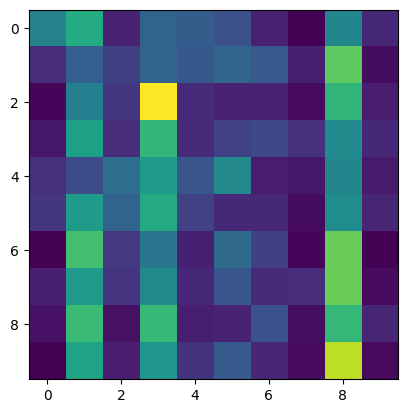

In [33]:
import matplotlib.pyplot as plt

plt.imshow(attn_weights[0, 0])

## Question 4b.

Actually, when we generate token per token, we should not attend on the future, it is not feasible (even though that's what stable diffusion is trying to do). Implement the masked self-attention, that ensures that attention weights for the $i$th row only attend before column $i$. Your implementation should be vectorized (no for loop, only tensor operations) and work for all batches and heads. Again, plot the attention weights using simply `plt.imshow`.

Hints: [triu](https://pytorch.org/docs/stable/generated/torch.triu.html) for upper triangular (check the `diagonal` parameter) and [masked_fill](https://pytorch.org/docs/stable/generated/torch.Tensor.masked_fill_.html#torch.Tensor.masked_fill_) according to boolean and a filling value. Then renormalize.

<img width="50%" src="https://substackcdn.com/image/fetch/w_1456,c_limit,f_webp,q_auto:good,fl_progressive:steep/https%3A%2F%2Fsubstack-post-media.s3.amazonaws.com%2Fpublic%2Fimages%2Fc51bfe11-c2cf-4ce5-95d4-4f8a57eac997_1026x1148.png" />

<img width="50%" src="https://substackcdn.com/image/fetch/w_1456,c_limit,f_webp,q_auto:good,fl_progressive:steep/https%3A%2F%2Fsubstack-post-media.s3.amazonaws.com%2Fpublic%2Fimages%2Fe1317a05-3542-4158-94bf-085109a5793a_1220x702.png" />

In [34]:
import torch

mask = torch.triu(torch.ones(batch_size, n_heads, seq_len, seq_len), diagonal=1)

In [35]:
attn_weights = attn_weights.masked_fill(mask.bool(), 0.)

In [36]:
# You're gonna carry that weight
assert attn_weights.shape == (batch_size, n_heads, seq_len, seq_len)
assert torch.all(attn_weights.sum(axis=3) - 1. < 1e6)  # Scores should sum to 1 for each batch and head
assert torch.all(torch.triu(attn_weights, diagonal=1) - 1. < 1e6)  # Zeroes on the diagonal and above

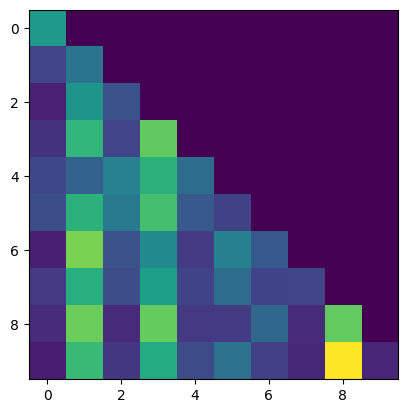

In [37]:
plt.imshow(attn_weights[0, 0])

Finally, `git clone https://github.com/karpathy/nanoGPT` and train a little GPT from scratch on character-level tokens using the GPUs of Polytechnique (should take 6 minutes, follow the README). You can also fine-tune an existing LLM on word-level tokens.

# References

https://magazine.sebastianraschka.com/p/understanding-and-coding-self-attention

## To know more

This (wrong) PyTorch tutorial contains a dataset for translation from [tatoeba.org](http://tatoeba.org/): https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html

Flash Attention is faster than attention $O(N^2)$.

https://github.com/Dao-AILab/flash-attention?tab=readme-ov-file

Download llama.cpp or ollama (Go wrapper over llama.cpp, more friendly) to have a GPT implemented in C++ on your laptop. Some multimodal LLMs like Pixtral or Gemma 3 can accept text and images as input, you will see this next week.

<img src="https://huggingface.co/blog/assets/02_how-to-generate/beam_search.png" />

There is a lot of work these days in how to retrieve nice answers from a LLM using scaling test-time compute or reasoning.

https://huggingface.co/blog/how-to-generate

https://huggingface.co/spaces/HuggingFaceH4/blogpost-scaling-test-time-compute